# BigEarthNet and Google Earth EDA 

This notebook is a modification of 0.1-tom-gather_california_data.ipynb

In [1]:
## ee package
!pip install earthengine-api --upgrade
!pip install Shapely
!pip install folium

     |████████████████████████████████| 150 kB 5.0 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 4.8 MB/s  eta 0:00:01
     |████████████████████████████████| 61 kB 63 kB/s s eta 0:00:01
     |████████████████████████████████| 95 kB 6.1 MB/s  eta 0:00:01
     |████████████████████████████████| 92 kB 1.7 MB/s  eta 0:00:01
     |████████████████████████████████| 75 kB 7.1 MB/s  eta 0:00:01
     |████████████████████████████████| 135 kB 12.6 MB/s eta 0:00:01
     |████████████████████████████████| 401 kB 9.6 MB/s eta 0:00:01
     |████████████████████████████████| 112 kB 17.3 MB/s eta 0:00:01
  Created wheel for earthengine-api: filename=earthengine_api-0.1.252-py3-none-any.whl size=178056 sha256=41b1bda44966bfa386d36603f5bb693271c213fd4e6a51f4daf138b827cfcf29
  Stored in directory: /root/.cache/pip/wheels/1a/45/75/ff50e0b9d00aac6f1bb844980397cdd5b3d8479c55ee572bc0
  Created wheel for httplib2shim: filename=httplib2shim-0.0.3-py2.py3-none-any.whl size=18056 sha256=1781757

In [2]:
import time
from math import sin, cos, sqrt, atan2, radians
import pandas as pd
import ee #https://developers.google.com/earth-engine/guides/python_install
from shapely.geometry import box
import folium
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import find_peaks

In [3]:
def authenticate():
    # Trigger the authentication flow.
    ee.Authenticate()

In [84]:
class MSIEarth():
    """
    MSIEarth is modified from MSICalifornia class
    """

    def __init__(self, lat1=1.0, lon1=1.0, lat2=0.0, lon2=0.0, year=2019):
        """
        Parameters:
            lat1: Latitude of upper left corner
            lon1: Longitude of upper left corner
            lat2: Latitude of lower rigth corner
            lon2: Longitude of lower rigth corner
            year: year the satellite data should pull images for
        """

        # Initialize the library.
        ee.Initialize()

        # Error handle parameter issues
        if lat1 >= -90 and lat1 <= 90:
            self.lat1 = lat1
        else:
            raise ValueError('Please enter float value for latitude 1 between -90 and 90')
            exit()

        if lat2 >= -90 and lat2 <= 90:
            self.lat2 = lat2
        else:
            raise ValueError('Please enter float value for latitude 2 between -90 and 90')
            exit()

        if lon1 >= -180 and lon1 <= 180:
            self.lon1 = lon1
        else:
            raise ValueError('Please enter float value for longitude 1 between -180 and 180')
            exit()

        if lon2 >= -180 and lon2 <= 180:
            self.lon2 = lon2
        else:
            raise ValueError('Please enter float value for longitude 2 between -180 and 180')
            exit()


        # (range is 2017 to year prior)
        if ((type(year) == int) and (year >= 2017 and year <= int(time.strftime("%Y")) - 1)):
            self.year = year
        else:
            raise ValueError(
                'Please enter an integer value for year > 2017 and less than the current year')
            exit()

        # initialize remaining variables
        self.label = []
        self.comment = dict()
        self.image = ee.Image()
        self.simple_image = ee.Image()
        self.base_asset_directory = None
        self.center_lat = 0.5*(lat1+lat2)
        self.center_lon = 0.5*(lon1+lon2)

        # Create the bounding box using GEE API
        self.aoi_ee = self.__create_bounding_box_ee()
        # Estimate the area of interest
        self.dist_lon = self.__calc_distance(self.lon1, 
                                             self.lat1, 
                                             self.lon2, 
                                             self.lat1)
        self.dist_lat = self.__calc_distance(self.lon1, 
                                             self.lat1, 
                                             self.lon1, 
                                             self.lat2)
        
        print('The selected area is approximately {:.2f} km by {:.2f} km'.format(
            self.dist_lon, self.dist_lat))

        self.model_projection = "EPSG:3857"

    def __create_bounding_box_ee(self):
        """
        Creates a rectangle for pulling image information using center coordinates and edge_len
        """
        lonv = np.array([self.lon1,self.lon2])
        latv = np.array([self.lat1,self.lat2])       
        return ee.Geometry.Rectangle([lonv.min(), 
                                      latv.min(), 
                                      lonv.max(), 
                                      latv.max()])

    def __create_bounding_box_shapely(self):
        """
        Returns a box for coordinates to plug in as an image add-on layer
        """
        lonv = np.array([self.lon1,self.lon2])
        latv = np.array([self.lat1,self.lat2]) 
        return box(lonv.min(),latv.min(),lonv.max(),latv.max())

    @staticmethod
    def __calc_distance(lon1, lat1, lon2, lat2):
        '''Calculates the distance between 2 coordinates'''
        # Reference: https://stackoverflow.com/questions/19412462/getting-distance-between-two-points-based-on-latitude-longitude
        # approximate radius of earth in km
        R = 6373.0
        lon1 = radians(lon1)
        lat1 = radians(lat1)
        lon2 = radians(lon2)
        lat2 = radians(lat2)
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
        c = 2 * atan2(sqrt(a), sqrt(1 - a))
        distance = R * c
        return distance

    def pull_Sentinel2_data(self):
              
        # 10 of 13 Spectral Bands are retained. 10th band has no surface reflectance per
        # http://bigearth.net/static/documents/BigEarthNet_IGARSS_2019.pdf
        
        # Also the baseline model only used the 10 and 20m bands (remove band 1 and 9)
        band_names = ['B1','B2', 'B3','B4', 
                      'B5','B6', 'B7','B8', 
                      'B8A','B9','B11','B12']
        
        random_month = np.random.randint(1,13)

        start_date = f'{self.year}-{random_month}-01'
        if random_month != 12:
            end_date = f'{self.year}-{random_month+1}-01'
        else:
            end_date = f'{self.year +1 }-1-01'

        self.Sentinel_MSI = (ee.ImageCollection('COPERNICUS/S2_SR')
                             .filterDate(start_date, end_date)
                             .filterBounds(self.aoi_ee)
                             .select(band_names)
                             .filter(ee.Filter.lt('CLOUDY_PIXEL_PERCENTAGE', 1))
                             .median().clip(self.aoi_ee))
        return random_month


    def plot_map(self):
        """
        Plot folium map using GEE api - the map includes are of interest box and associated ndvi readings
        """

        def add_ee_layer(self, ee_object, vis_params, show, name):
            """
            Checks if image object classifies as ImageCollection, FeatureCollection, Geometry or single Image
            and adds to folium map accordingly
            """
            try:
                if isinstance(ee_object, ee.image.Image):
                    map_id_dict = ee.Image(ee_object).getMapId(vis_params)
                    folium.raster_layers.TileLayer(
                        tiles=map_id_dict['tile_fetcher'].url_format,
                        attr='Google Earth Engine',
                        name=name,
                        overlay=True,
                        control=True,
                        show=show
                    ).add_to(self)
                elif isinstance(ee_object, ee.imagecollection.ImageCollection):
                    ee_object_new = ee_object.median()
                    map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
                    folium.raster_layers.TileLayer(
                        tiles=map_id_dict['tile_fetcher'].url_format,
                        attr='Google Earth Engine',
                        name=name,
                        overlay=True,
                        control=True,
                        show=show
                    ).add_to(self)
                elif isinstance(ee_object, ee.geometry.Geometry):
                    folium.GeoJson(
                        data=ee_object.getInfo(),
                        name=name,
                        overlay=True,
                        control=True
                    ).add_to(self)
                elif isinstance(ee_object, ee.featurecollection.FeatureCollection):
                    ee_object_new = ee.Image().paint(ee_object, 0, 2)
                    map_id_dict = ee.Image(ee_object_new).getMapId(vis_params)
                    folium.raster_layers.TileLayer(
                        tiles=map_id_dict['tile_fetcher'].url_format,
                        attr='Google Earth Engine',
                        name=name,
                        overlay=True,
                        control=True,
                        show=show
                    ).add_to(self)

            except:
                print("Could not display {}".format(name))

        # Add EE drawing method to folium.
        folium.Map.add_ee_layer = add_ee_layer

        myMap = folium.Map(location=[self.center_lat, self.center_lon], zoom_start=15)
        #aoi_shapely = self.__create_bounding_box_shapely()
        #folium.GeoJson(aoi_shapely, name="Area of Interest").add_to(myMap)

        
        # Add Sentinel-2 RGB quarterly layers
        start = time.time()
        visParams = {'max': 3000}
        # Add MSI layer for July
        myMap.add_ee_layer(self.Sentinel_MSI.select(['B2','B3','B4']), visParams, show=False, name="Sentinel2A")
        end = time.time()
        print("ADDED S2 RGB LAYERS \t\t--> " + str(round((end - start) / 60, 2)) + " min")

        return myMap

    def write_image_google_drive(self, filename):
        """
        Writes predicted image out as an image to Google Drive as individual TIF files
        They will need to be combined after the fact
        """
        bands = ['B1','B2', 'B3', 'B4',
                 'B5','B6', 'B7', 'B8', 
                 'B9','B8A','B11', 'B12']
        tasks = []
        for band in bands:
            tasks.append(ee.batch.Export.image.toDrive(
                crs=self.model_projection,
                region=self.aoi_ee,
                image=self.Sentinel_MSI.select(band),
                description=f'{filename}_msi_{band}',
                scale = 10,
                maxPixels=1e13))
        
        print(f"Writing To Google Drive filename = {filename}.tif")
        
        for t in tasks:
                t.start()
        

In [5]:
authenticate()

Enter verification code: 4/1AY0e-g6FmeeDQLbcR-Xup21ZzbsI8uTT55Udc8eE12y9iNkJixl1h7i3ZwU

Successfully saved authorization token.


## BigEarthNEt Example

In [97]:
import os
from PIL import Image
import cv2
import numpy as np
# from osgeo import gdal
import matplotlib.pyplot as plt
import json
import datetime 

In [98]:
path = '/workspace/app/data/raw/BigEarthNet/S2A_MSIL2A_20171002T112111_43_58'

def fn():       # 1.Get file names from directory
    file_list=os.listdir(path)
    return file_list 

 #2.To rename files
file_list = fn()

In [99]:
for file in file_list:
    print(file)

S2A_MSIL2A_20171002T112111_43_58_labels_metadata.json
S2A_MSIL2A_20171002T112111_43_58_B07.tif
S2A_MSIL2A_20171002T112111_43_58_B8A.tif
S2A_MSIL2A_20171002T112111_43_58_B01.tif
S2A_MSIL2A_20171002T112111_43_58_B11.tif
S2A_MSIL2A_20171002T112111_43_58_B12.tif
S2A_MSIL2A_20171002T112111_43_58_B09.tif
S2A_MSIL2A_20171002T112111_43_58_B02.tif
S2A_MSIL2A_20171002T112111_43_58_B06.tif
S2A_MSIL2A_20171002T112111_43_58_B03.tif
S2A_MSIL2A_20171002T112111_43_58_B04.tif
S2A_MSIL2A_20171002T112111_43_58_B05.tif
S2A_MSIL2A_20171002T112111_43_58_B08.tif


In [100]:
band_be = {}
for file in file_list:
    if '.tif' in file:
        band_be[file[-7:-4]] = Image.open(os.path.join(path,file))
    elif '.json' in file:
        jfile = file

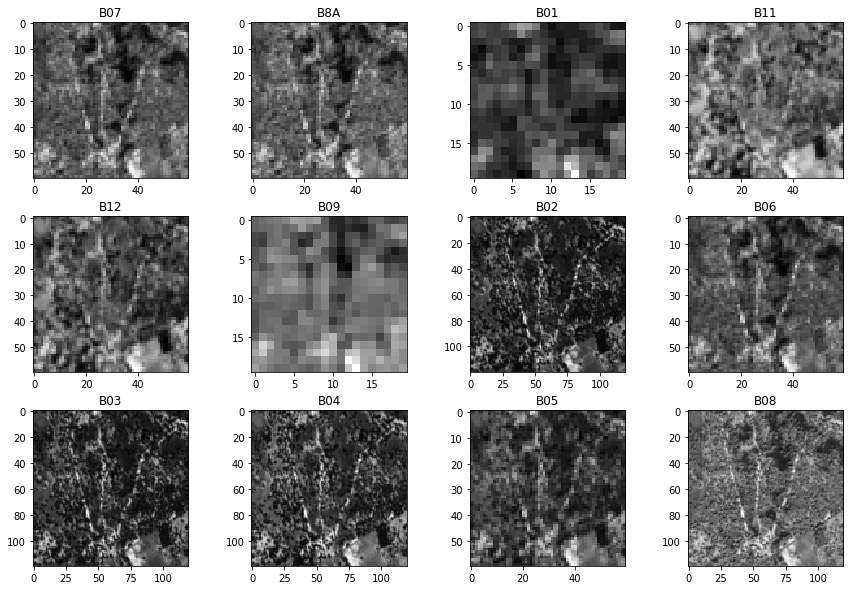

In [101]:
fig = plt.figure(figsize=(15,10))
cont = 1
for bnd in band_be.keys():
    image_sequence = band_be[bnd].getdata()
    image_array = np.array(image_sequence)
    ishp = image_array.shape[0]
    ishp = int(np.sqrt(ishp))
    image_array = image_array.reshape(ishp,ishp)
    ax = fig.add_subplot(3,4,cont)
    ax.imshow(image_array,interpolation='nearest',cmap='gray')
    ax.set_title(bnd)
    cont += 1
                 
plt.subplots_adjust(wspace=0.2, hspace=0.25)

In [11]:
with open(os.path.join(path,jfile)) as json_file:
    mdata = json.load(json_file)

    dxy=mdata['coordinates']
    sdate = mdata['acquisition_date']
    date = datetime.datetime.strptime(sdate, '%Y-%m-%d %H:%M:%S')
    idx=mdata['projection'].find('central_meridian')
    idz=mdata['projection'].find('UTM zone')

    mer = mdata['projection'][idx+len('central_meridian')+2:idx+len('central_meridian')+4]
    zon = mdata['projection'][idz+len('UTM zone')+1:idz+len('UTM zone')+3]

print(dxy)
print(mer)
print(zon)
print(date.year)

{'ulx': 551580, 'uly': 4230420, 'lrx': 552780, 'lry': 4229220}
-9
29
2017


## Degree to distance calculation
- One degree of latitude equals approximately 364,080 feet (69 miles), one minute equals 6,068 feet (1.15 miles), and one-second equals 101 feet. 
- One-degree of longitude equals 288,200 feet (54.6 miles), one minute equals 4,800 feet (0.91 mile), and one second equals 80 feet.
- 1.60934 km per mile
- 9748 square kilometers per squared degree

https://www.ibm.com/developerworks/java/library/j-coordconvert/index.html

In [12]:
import math
def utmToLatLng(zone, easting, northing, northernHemisphere=True):
    if not northernHemisphere:
        northing = 10000000 - northing
    a = 6378137
    e = 0.081819191
    e1sq = 0.006739497
    k0 = 0.9996
    arc = northing / k0
    mu = arc / (a * (1 - math.pow(e, 2) / 4.0 - 3 * math.pow(e, 4) / 64.0 - 5 * math.pow(e, 6) / 256.0))
    ei = (1 - math.pow((1 - e * e), (1 / 2.0))) / (1 + math.pow((1 - e * e), (1 / 2.0)))
    ca = 3 * ei / 2 - 27 * math.pow(ei, 3) / 32.0
    cb = 21 * math.pow(ei, 2) / 16 - 55 * math.pow(ei, 4) / 32
    cc = 151 * math.pow(ei, 3) / 96
    cd = 1097 * math.pow(ei, 4) / 512
    phi1 = mu + ca * math.sin(2 * mu) + cb * math.sin(4 * mu) + cc * math.sin(6 * mu) + cd * math.sin(8 * mu)
    n0 = a / math.pow((1 - math.pow((e * math.sin(phi1)), 2)), (1 / 2.0))
    r0 = a * (1 - e * e) / math.pow((1 - math.pow((e * math.sin(phi1)), 2)), (3 / 2.0))
    fact1 = n0 * math.tan(phi1) / r0
    _a1 = 500000 - easting
    dd0 = _a1 / (n0 * k0)
    fact2 = dd0 * dd0 / 2
    t0 = math.pow(math.tan(phi1), 2)
    Q0 = e1sq * math.pow(math.cos(phi1), 2)
    fact3 = (5 + 3 * t0 + 10 * Q0 - 4 * Q0 * Q0 - 9 * e1sq) * math.pow(dd0, 4) / 24
    fact4 = (61 + 90 * t0 + 298 * Q0 + 45 * t0 * t0 - 252 * e1sq - 3 * Q0 * Q0) * math.pow(dd0, 6) / 720
    lof1 = _a1 / (n0 * k0)
    lof2 = (1 + 2 * t0 + Q0) * math.pow(dd0, 3) / 6.0
    lof3 = (5 - 2 * Q0 + 28 * t0 - 3 * math.pow(Q0, 2) + 8 * e1sq + 24 * math.pow(t0, 2)) * math.pow(dd0, 5) / 120
    _a2 = (lof1 - lof2 + lof3) / math.cos(phi1)
    _a3 = _a2 * 180 / math.pi
    latitude = 180 * (phi1 - fact1 * (fact2 + fact3 + fact4)) / math.pi
    if not northernHemisphere:
        latitude = -latitude
    longitude = ((zone > 0) and (6 * zone - 183.0) or 3.0) - _a3
    return (latitude, longitude)

### Calculate latitude and longitude from UTM

In [ ]:
{'ulx': 551580, 'uly': 4230420, 'lrx': 552780, 'lry': 4229220}
-9
29
2017

In [47]:
utmToLatLng(zone, easting, northing, northernHemisphere=True):

array([50.029, 50.03 ])

In [13]:
lat1,lon1 = utmToLatLng(int(zon),float(dxy['ulx']),float(dxy['uly']))
lat2,lon2 = utmToLatLng(int(zon),float(dxy['lrx']),float(dxy['lry']))

In [79]:
year = 2020

# Iterate over range of lats and longs
# Instantiate the model
print('Evaluating irrigation at ({}, {}) and ({}, {})'.format(lat1,lon1,lat2,lon2))
        
# Instantiate the model
model = MSIEarth(lat1,lon1,lat2,lon2,year=year)
month = model.pull_Sentinel2_data()
base_filename = f'S2SR_{month}_{year}_{lat1}_{lon1}'    
model.write_image_google_drive(base_filename)      

Evaluating irrigation at (38.220278955932464, -8.410746102785305) and (38.20939484833668, -8.397127134596012)
The selected area is approximately 1.19 km by 1.21 km
Writing To Google Drive filename = S2SR_11_2020_38.220278955932464_-8.410746102785305.tif


In [82]:
%%time
model.plot_map()

ADDED S2 RGB LAYERS 		--> 0.01 min
CPU times: user 6.77 ms, sys: 153 µs, total: 6.93 ms
Wall time: 315 ms


The distance was calculated from latitude and longitude by using the ***haversine*** equation (https://www.movable-type.co.uk/scripts/latlong.html).
Haversine equations are as follows:

$$a = sin^2 \left( \frac{\Delta \phi}{2} \right) + cos \phi_1 ⋅ cos \phi_2 ⋅ sin^2 \left( \frac{\Delta  \lambda}{2} \right)$$ 
$$c = 2 . atan2 \left( \sqrt{a},\sqrt{1-a} \right)$$
$$d = R ⋅ c$$

where \\(\phi\\) is the latitude,\\(\lambda\\) is the longitude, ***d*** is the distance in Kilometers, ***R*** is the earth radius in Km (6371).

In [13]:
# Calculating the distance between two points with their coordinates
def distance(lat1,lon1,lat0,lon0):
    r = 6371.0 # in km
    lat0 = float(lat0)*m.pi/180.0
    lon0 = float(lon0)*m.pi/180.0
    lat1 = float(lat1)*m.pi/180.0
    lon1 = float(lon1)*m.pi/180.0
  
    a = m.sin(0.5*(lat1-lat0))**2 + m.cos(lat0)*m.cos(lat1)*m.sin(0.5*(lon1-lon0))**2
    c = 2.0*m.atan2(m.sqrt(a),m.sqrt(1-a))

    return r*c

### BigEarthNet PAtches from Google Earth Engein 

In [126]:
path = '/workspace/app/data/raw/GoogleEE/BigEarthNet/S2A_MSIL2A_20171002T112111_43_58'

def fn():       # 1.Get file names from directory
    file_list=os.listdir(path)
    return file_list 

 #2.To rename files
file_list = fn()

for file in file_list:
    print(file)

S2SR_6_2019_38.220278955932464_-8.410746102785305_msi_B4.tif
S2SR_5_2018_38.220278955932464_-8.410746102785305_msi_B12.tif
S2SR_5_2018_38.220278955932464_-8.410746102785305_msi_B9.tif
S2SR_11_2020_38.220278955932464_-8.410746102785305_msi_B12.tif
S2SR_11_2020_38.220278955932464_-8.410746102785305_msi_B1.tif
S2SR_6_2019_38.220278955932464_-8.410746102785305_msi_B6.tif
S2SR_11_2020_38.220278955932464_-8.410746102785305_msi_B11.tif
S2SR_5_2018_38.220278955932464_-8.410746102785305_msi_B8.tif
S2SR_5_2018_38.220278955932464_-8.410746102785305_msi_B5.tif
S2SR_11_2020_38.220278955932464_-8.410746102785305_msi_B9.tif
S2SR_11_2020_38.220278955932464_-8.410746102785305_msi_B7.tif
S2SR_5_2018_38.220278955932464_-8.410746102785305_msi_B6.tif
S2SR_5_2018_38.220278955932464_-8.410746102785305_msi_B2.tif
S2SR_6_2019_38.220278955932464_-8.410746102785305_msi_B7.tif
S2SR_5_2018_38.220278955932464_-8.410746102785305_msi_B1.tif
S2SR_11_2020_38.220278955932464_-8.410746102785305_msi_B8.tif
S2SR_11_2020_38

In [128]:
import rasterio
band = {}
for file in file_list:
    idate = file.split('_')[1]+'-'+file.split('_')[2]
    if idate not in band.keys():
        band[idate] = {}
    tix=file.find('msi_')
    band[idate][file[tix+4:-4]]  = rasterio.open(os.path.join(path,file))

In [130]:
band.keys()

dict_keys(['6-2019', '5-2018', '11-2020'])

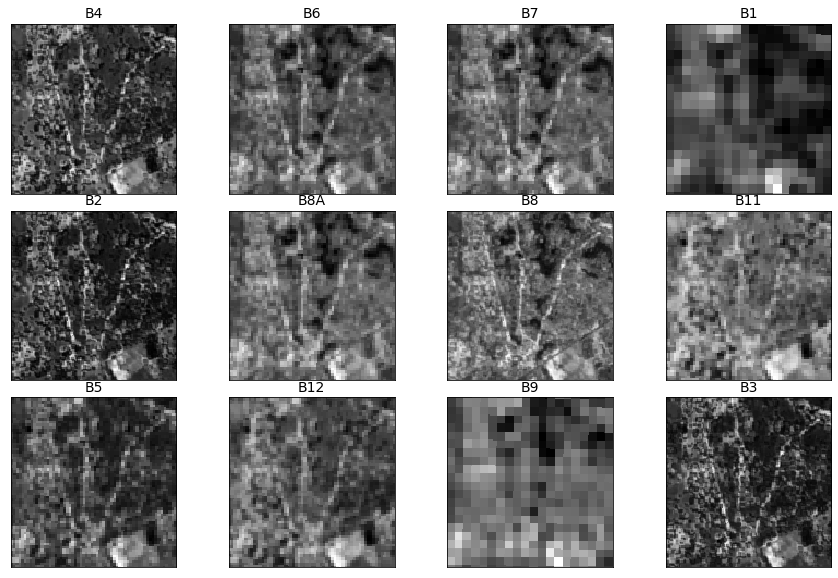

In [118]:
ksel = '6-2019'
fig = plt.figure(figsize=(15,10))
cont = 1

sband = band[ksel]
for idx in sband.keys(): # 13 bands
    raster_band = np.array(sband[idx].read())
    img = np.array(raster_band)
    img1 = img.reshape(img.shape[1],img.shape[2])

    plt.subplots_adjust(hspace=.1)
    plt.subplot(3,4,cont)
    plt.imshow(img1,interpolation='nearest',cmap='gray')
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.title(idx, fontsize=14)
    cont += 1

In [122]:
def rgb_benet(arr_r,arr_g,arr_b):
    
    image_sequence = arr_r.getdata()
    image_array = np.array(image_sequence)
    ishp = image_array.shape[0]
    ishp = int(np.sqrt(ishp))
    red1 = image_array.reshape(ishp,ishp)
    
    image_sequence = arr_g.getdata()
    image_array = np.array(image_sequence)
    ishp = image_array.shape[0]
    ishp = int(np.sqrt(ishp))
    green1 = image_array.reshape(ishp,ishp)
    
    image_sequence = arr_b.getdata()
    image_array = np.array(image_sequence)
    ishp = image_array.shape[0]
    ishp = int(np.sqrt(ishp))
    blue1 = image_array.reshape(ishp,ishp)
    
    mv = np.array([red1.max(),green1.max(),blue1.max()]).max()

    red1 = red1/mv
    green1 = green1/mv
    blue1 = blue1/mv
    
    rgbArray = np.zeros((red1.shape[0],red1.shape[1],3), 'uint8')
    rgbArray[...,0] = red1 *256
    rgbArray[...,1] = green1 *256
    rgbArray[...,2] = blue1 *256
    
    return rgbArray

def rgb_google(arr_r,arr_g,arr_b):
    raster_r = np.array(arr_r.read())
    red = np.array(raster_r)
    red1 = red.reshape(red.shape[1],red.shape[2])

    raster_g = np.array(arr_g.read())
    green = np.array(raster_g)
    green1 = green.reshape(green.shape[1],green.shape[2])
    
    raster_b = np.array(arr_b.read())
    blue = np.array(raster_b)
    blue1 = blue.reshape(blue.shape[1],blue.shape[2])
    
    mv = np.array([red1.max(),green1.max(),blue1.max()]).max()

    red1 = red1/mv
    green1 = green1/mv
    blue1 = blue1/mv
    
    rgbArray = np.zeros((red.shape[1],red.shape[2],3), 'uint8')
    rgbArray[...,0] = red1 *256
    rgbArray[...,1] = green1 *256
    rgbArray[...,2] = blue1 *256
    
    return rgbArray

### BigEarthNet Display

Text(0.5, 1.0, 'BENet 10-2017')

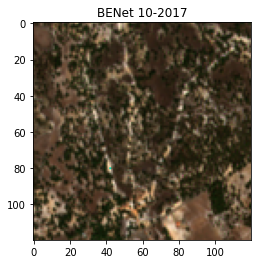

In [125]:
fig = plt.figure()
img_rgb = rgb_benet(band_be['B04'],band_be['B03'],band_be['B02'])
plt.imshow(img_rgb)
plt.title('BENet '+str(date.month)+'-'+str(date.year))

### Google Earth Display

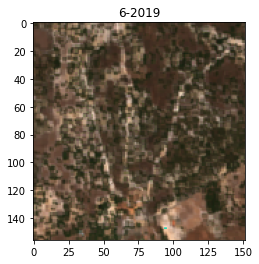

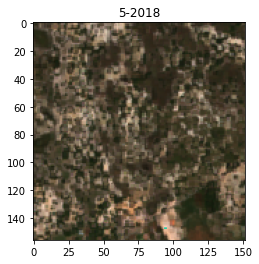

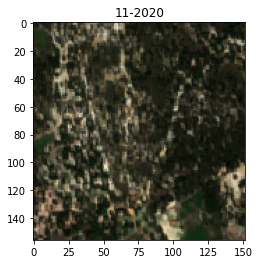

In [131]:
for imgd in band.keys():
    fig = plt.figure()
    img_rgb = rgb_google(band[imgd]['B4'],band[imgd]['B3'],band[imgd]['B2'])
    plt.imshow(img_rgb)
    plt.title(imgd)